In [27]:
import json\
import numpy
import requests
from bs4 import BeautifulSoup
from espncricinfo.exceptions import MatchNotFoundError, NoScorecardError
import pandas as pd

class Match(object):
    def __init__(self, match_id):
        self.match_id = match_id
        self.match_url = f"https://site.api.espn.com/apis/site/v2/sports/cricket/8048/summary?event={match_id}"
        self.json_url = f"https://www.espncricinfo.com/matches/engine/match/{match_id}.json"
        self.json = self.get_json()
        self.json_api = self.get_json_api()
        self.description = self.get_description()
        self.full_scorecard_url = self.get_full_scorecard_url()
        self.toss = self.get_toss()
        self.team1 = self.get_team1()
        self.team2 = self.get_team2()
        self.team1_batting_df = self.get_team1_batting_df()
        self.team2_batting_df = self.get_team2_batting_df()
        self.team1_bowling_df = self.get_team1_bowling_df()
        self.team2_bowling_df = self.get_team2_bowling_df()
        self.dream11_points = self.get_dream11_points()
        
    def get_json(self):
        r = requests.get(self.json_url)
        if r.status_code == 404:
            raise MatchNotFoundError
        elif 'Scorecard not yet available' in r.text:
            raise NoScorecardError
        else:
            return r.json()
    
    def get_json_api(self):
        r = requests.get(self.match_url)
        if r.status_code == 404:
            raise MatchNotFoundError
        elif 'Scorecard not yet available' in r.text:
            raise NoScorecardError
        else:
            return r.json()
        
    def get_full_scorecard_url(self):
        url  = self.description
        matchName = url.split(",")[1].split(":")[1].strip().split(" ")[:-2]
        firstHalf = '-'.join(matchName).lower().replace("-v-", "-vs-")
        matchNo = url.split(",")[1].split(":")[0].replace(" ","-").lower()
        finalurl = firstHalf + matchNo + "-" + str(self.match_id)
        return f"https://www.espncricinfo.com/series/indian-premier-league-2024-1410320/{finalurl}/full-scorecard"
    
    def get_description(self):
        return self.json['description']
    
    def get_toss(self):
        return self.json_api['gameInfo']['venue']['fullName']
    
    def get_team1(self):
        team = []
        for i in self.json_api['rosters'][0]['roster']:
             team.append(i['athlete']['name'])
        return team
    
    def get_team2(self):
        team = []
        for i in self.json_api['rosters'][1]['roster']:
             team.append(i['athlete']['name'])
        return team
    
    def get_team1_batting_df(self):
        r = requests.get(self.full_scorecard_url)
        soup = BeautifulSoup(r.content, 'html.parser')
        df = pd.DataFrame(columns= ['Name', "Wicket", "Runs", "Balls", "Fours", "Sixes"])
        tables = soup.find_all('table')
        brows = tables[0].findAll('tr')[1:-4]
        for brow in brows[::2]:
            x  = brow.findAll('td')
            df.loc[len(df)] = [x[0].text, x[1].text, x[2].text, x[3].text, x[5].text, x[6].text]
        df[["Runs", "Balls", "Fours", "Sixes"]] = df[["Runs", "Balls", "Fours", "Sixes"]].astype(float)
        df["Strike Rate"] = (df["Runs"] / df["Balls"] * 100).round(2)
        return df

    def get_team2_batting_df(self):
        r = requests.get(self.full_scorecard_url)
        soup = BeautifulSoup(r.content, 'html.parser')
        df = pd.DataFrame(columns= ['Name', "Wicket", "Runs", "Balls", "Fours", "Sixes"])
        tables = soup.find_all('table')
        brows = tables[2].findAll('tr')[1:-4]
        for brow in brows[::2]:
            x  = brow.findAll('td')
            df.loc[len(df)] = [x[0].text, x[1].text, x[2].text, x[3].text, x[5].text, x[6].text]
        df[["Runs", "Balls", "Fours", "Sixes"]] = df[["Runs", "Balls", "Fours", "Sixes"]].astype(float)
        df["Strike Rate"] = (df["Runs"] / df["Balls"] * 100).round(2)
        return df
    
    def get_team1_bowling_df(self):
        table = pd.read_html(self.full_scorecard_url)
        df = table[1]
        df = df[~df['BOWLING'].str[0].str.isdigit()]
        df.rename(columns = {'O':'Overs', 'M' : 'Maidens', 'R' : 'Runs', 'W' : 'Wickets', 'ECON' : 'Economy'} , inplace= True)
        df[["Overs", "Economy",]] = df[["Overs","Economy"]].astype(float)
        df[["Maidens", "Runs", "Wickets", "0s", "4s", "6s", "WD", "NB"]] = df[["Maidens", "Runs", "Wickets", "0s", "4s", "6s", "WD", "NB"]].astype("int")
        return df
    
    def get_team2_bowling_df(self):
        table = pd.read_html(self.full_scorecard_url)
        df = table[3]
        df = df[~df['BOWLING'].str[0].str.isdigit()]
        df.rename(columns = {'O':'Overs', 'M' : 'Maidens', 'R' : 'Runs', 'W' : 'Wickets', 'ECON' : 'Economy'} , inplace= True)
        df[["Overs", "Economy",]] = df[["Overs","Economy"]].astype(float)
        df[["Maidens", "Runs", "Wickets", "0s", "4s", "6s", "WD", "NB"]] = df[["Maidens", "Runs", "Wickets", "0s", "4s", "6s", "WD", "NB"]].astype("int")
        return df
    
    def get_dream11_points(self):
        return None
    



SyntaxError: invalid syntax (2799637093.py, line 2)

In [ ]:
matchNumber = 1426293

m = Match(matchNumber)
m.team1

/tmp/ipykernel_3560/2686147416.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {'O':'Overs', 'M' : 'Maidens', 'R' : 'Runs', 'W' : 'Wickets', 'ECON' : 'Economy'} , inplace= True)
/tmp/ipykernel_3560/2686147416.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["Overs", "Economy",]] = df[["Overs","Economy"]].astype(float)
/tmp/ipykernel_3560/2686147416.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

['Ishan Kishan',
 'Rohit Sharma',
 'Naman Dhir',
 'Suryakumar Yadav',
 'Tilak Varma',
 'Hardik Pandya',
 'Tim David',
 'Anshul Kamboj',
 'Piyush Chawla',
 'Jasprit Bumrah',
 'Nuwan Thushara']

In [ ]:
m.team1_batting_df

m.team2_bowling_df

,BOWLING,Overs,Maidens,Runs,Wickets,Economy,0s,4s,6s,WD,NB
0,Bhuvneshwar Kumar,4.0,1,22,1,5.50,17,3,1,1,0
2,Marco Jansen,3.0,0,45,1,15.00,5,5,2,2,0
4,Pat Cummins,4.0,1,35,1,8.75,12,4,2,1,0
6,T Natarajan,3.2,0,31,0,9.30,8,4,1,0,0
7,Nitish Kumar Reddy,2.0,0,16,0,8.00,5,3,0,0,0
8,Shahbaz Ahmed,1.0,0,11,0,11.00,1,2,0,0,0


In [28]:
x = m.team1_batting_df


x['Fantasy Points'] = x['Runs'] + x['Fours'] + x['Sixes']*2
x['Fantasy Points'] = x['Runs'] + x['Fours'] + x['Sixes']*2
x['Fantasy Points'] = numpy.where(x['Runs'] > 50, x['Fantasy Points'] + 8, x['Fantasy Points'])
x['Fantasy Points'] = numpy.where(x['Runs'] > 100, x['Fantasy Points'] + 8, x['Fantasy Points'])
x['Fantasy Points'] = numpy.where((x['Runs'] == 0) & (x['Wicket'] != 'not out '), x['Fantasy Points'] - 2 , x['Fantasy Points'])

y = m.team1_bowling_df


y['Fantasy Points'] = y['Wickets']*25 + y['Maidens']*8 
y['Fantasy Points'] = numpy.where(y['Wickets'] >= 4, y['Fantasy Points'] + 8, y['Fantasy Points'])
y['Fantasy Points'] = numpy.where(y['Wickets'] >= 5, y['Fantasy Points'] + 8, y['Fantasy Points'])
y['Fantasy Points'] = numpy.where((y['Economy'] <= 6) & (y['Overs'] >=2) , y['Fantasy Points'] +2, y['Fantasy Points'])
y['Fantasy Points'] = numpy.where((y['Economy'] <= 5) & (y['Overs'] >=2), y['Fantasy Points'] +2, y['Fantasy Points'])

y

,BOWLING,Overs,Maidens,Runs,Wickets,Economy,0s,4s,6s,WD,NB,Fantasy Points
0,Nuwan Thushara,4.0,0,42,0,10.50,7,3,1,3,1,0
1,Anshul Kamboj,4.0,0,42,1,10.50,9,3,2,1,2,25
3,Jasprit Bumrah,4.0,0,23,1,5.75,9,2,0,1,0,27
5,Hardik Pandya,4.0,0,31,3,7.75,7,4,0,1,0,75
7,Piyush Chawla,4.0,0,33,3,8.25,7,1,2,2,0,75


In [ ]:

# Same for Strike Rate
# x["Fantasy Points"][x["Runs"] > 50] = x["Fantasy Points"] + 8
# x["Fantasy Points"][x["Runs"] > 100] = x["Fantasy Points"] + 16
# x["Fantasy Points"][x["Runs"] == 0] = x["Fantasy Points"] - 2

# y["Fantasy Points"] = y["Runs"] + y["Fours"] + y["Sixes"]*2
# y["Fantasy Points"][y["Runs"] > 50] = y["Fantasy Points"] + 8
# y["Fantasy Points"][y["Runs"] > 100] = y["Fantasy Points"] + 16
# y["Fantasy Points"][y["Runs"] == 0] = y["Fantasy Points"] - 2

x


,Name,Wicket,Runs,Balls,Fours,Sixes,Strike Rate,Fantasy Points
0,Wriddhiman Saha †,c †Karthik b Mohammed Siraj,1.0,7.0,0.0,0.0,14.29,1.0
1,Shubman Gill (c),c Vyshak b Mohammed Siraj,2.0,7.0,0.0,0.0,28.57,2.0
2,Sai Sudharsan,c Kohli b Green,6.0,14.0,0.0,0.0,42.86,6.0
3,M Shahrukh Khan,run out (Kohli),37.0,24.0,5.0,1.0,154.17,44.0
4,David Miller,c Maxwell b Sharma,30.0,20.0,3.0,2.0,150.00,37.0
5,Rahul Tewatia,c Vyshak b Yash Dayal,35.0,21.0,5.0,1.0,166.67,42.0
6,Rashid Khan,b Yash Dayal,18.0,14.0,2.0,1.0,128.57,22.0
7,Vijay Shankar,c Mohammed Siraj b Vyshak,10.0,7.0,2.0,0.0,142.86,12.0
8,Manav Suthar,c Swapnil Singh b Vyshak,1.0,2.0,0.0,0.0,50.00,1.0
9,Mohit Sharma,run out (†Karthik/Vyshak),0.0,1.0,0.0,0.0,0.00,-2.0


<Axes: xlabel='Name'>

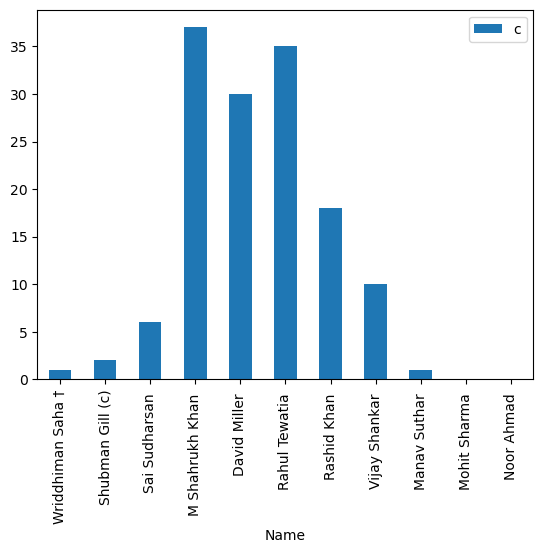

In [ ]:
# x["Fantasy Points"].plot()
x.plot.bar(x='Name', y='Runs', label='c')